# Import necessary libraries

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import string

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

 # Prepare Dataset

In [2]:
review_df = pd.read_csv('raw_data/reviews.csv', index_col=0)
rating_df = pd.read_csv('raw_data/rating.csv')

In [3]:
review_df.head(2)

,index,Datetime,Name,OverallRating,ReviewHeader,ReviewBody
0,0,19th November 2023,L Keele,1.0,"""Service level far worse then Ryanair""",4 Hours before takeoff we received a Mail stat...
1,1,19th November 2023,Austin Jones,3.0,"""do not upgrade members based on status""",I recently had a delay on British Airways from...


In [4]:
rating_df.head(2)

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,1.0,L Keele,19th November 2023,True,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,3.0,Austin Jones,19th November 2023,True,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0


In [5]:
df = rating_df.merge(review_df, on=['Name', 'OverallRating', 'Datetime']).drop(columns='index')

In [6]:
df.shape

(3787, 19)

In [7]:
rating_df.shape

(3701, 17)

In [8]:
review_df.shape

(3701, 6)

In [9]:
df.head()

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,ReviewHeader,ReviewBody
0,1.0,L Keele,19th November 2023,True,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN,"""Service level far worse then Ryanair""",4 Hours before takeoff we received a Mail stat...
1,3.0,Austin Jones,19th November 2023,True,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0,"""do not upgrade members based on status""",I recently had a delay on British Airways from...
2,8.0,M A Collie,16th November 2023,False,Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN,"""Flight was smooth and quick""","Boarded on time, but it took ages to get to th..."
3,1.0,Nigel Dean,16th November 2023,True,Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN,"""Absolutely hopeless airline""","5 days before the flight, we were advised by B..."
4,1.0,Gaylynne Simpson,14th November 2023,False,Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0,"""Customer Service is non existent""","We traveled to Lisbon for our dream vacation, ..."


# EDA

## Investigating the dataset and select important features.

In [10]:
# look for missing values in data
round(df.isnull().sum()/(df.shape[0]), 2) *100

OverallRating             0.0
Name                      0.0
Datetime                  0.0
VerifiedReview            0.0
TypeOfTraveller          21.0
SeatType                  0.0
Route                    21.0
DateFlown                21.0
SeatComfort               3.0
CabinStaffService         3.0
GroundService            23.0
ValueForMoney             0.0
Recommended               0.0
Aircraft                 48.0
Food&Beverages           10.0
InflightEntertainment    31.0
Wifi&Connectivity        84.0
ReviewHeader              0.0
ReviewBody                0.0
dtype: float64

In [11]:
# look for data type of indivisual columns and sense check if they are what you think they should be
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3786
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallRating          3782 non-null   float64
 1   Name                   3787 non-null   object 
 2   Datetime               3787 non-null   object 
 3   VerifiedReview         3787 non-null   bool   
 4   TypeOfTraveller        2990 non-null   object 
 5   SeatType               3785 non-null   object 
 6   Route                  2986 non-null   object 
 7   DateFlown              2983 non-null   object 
 8   SeatComfort            3671 non-null   float64
 9   CabinStaffService      3660 non-null   float64
 10  GroundService          2913 non-null   float64
 11  ValueForMoney          3786 non-null   float64
 12  Recommended            3787 non-null   object 
 13  Aircraft               1966 non-null   object 
 14  Food&Beverages         3398 non-null   float64
 15  Infl

1. Found out that `Wifi&Connectivity` and `Aircraft` are missing a lot of data.
2. Date columns are not `datetime` types.

### Handle missing Data

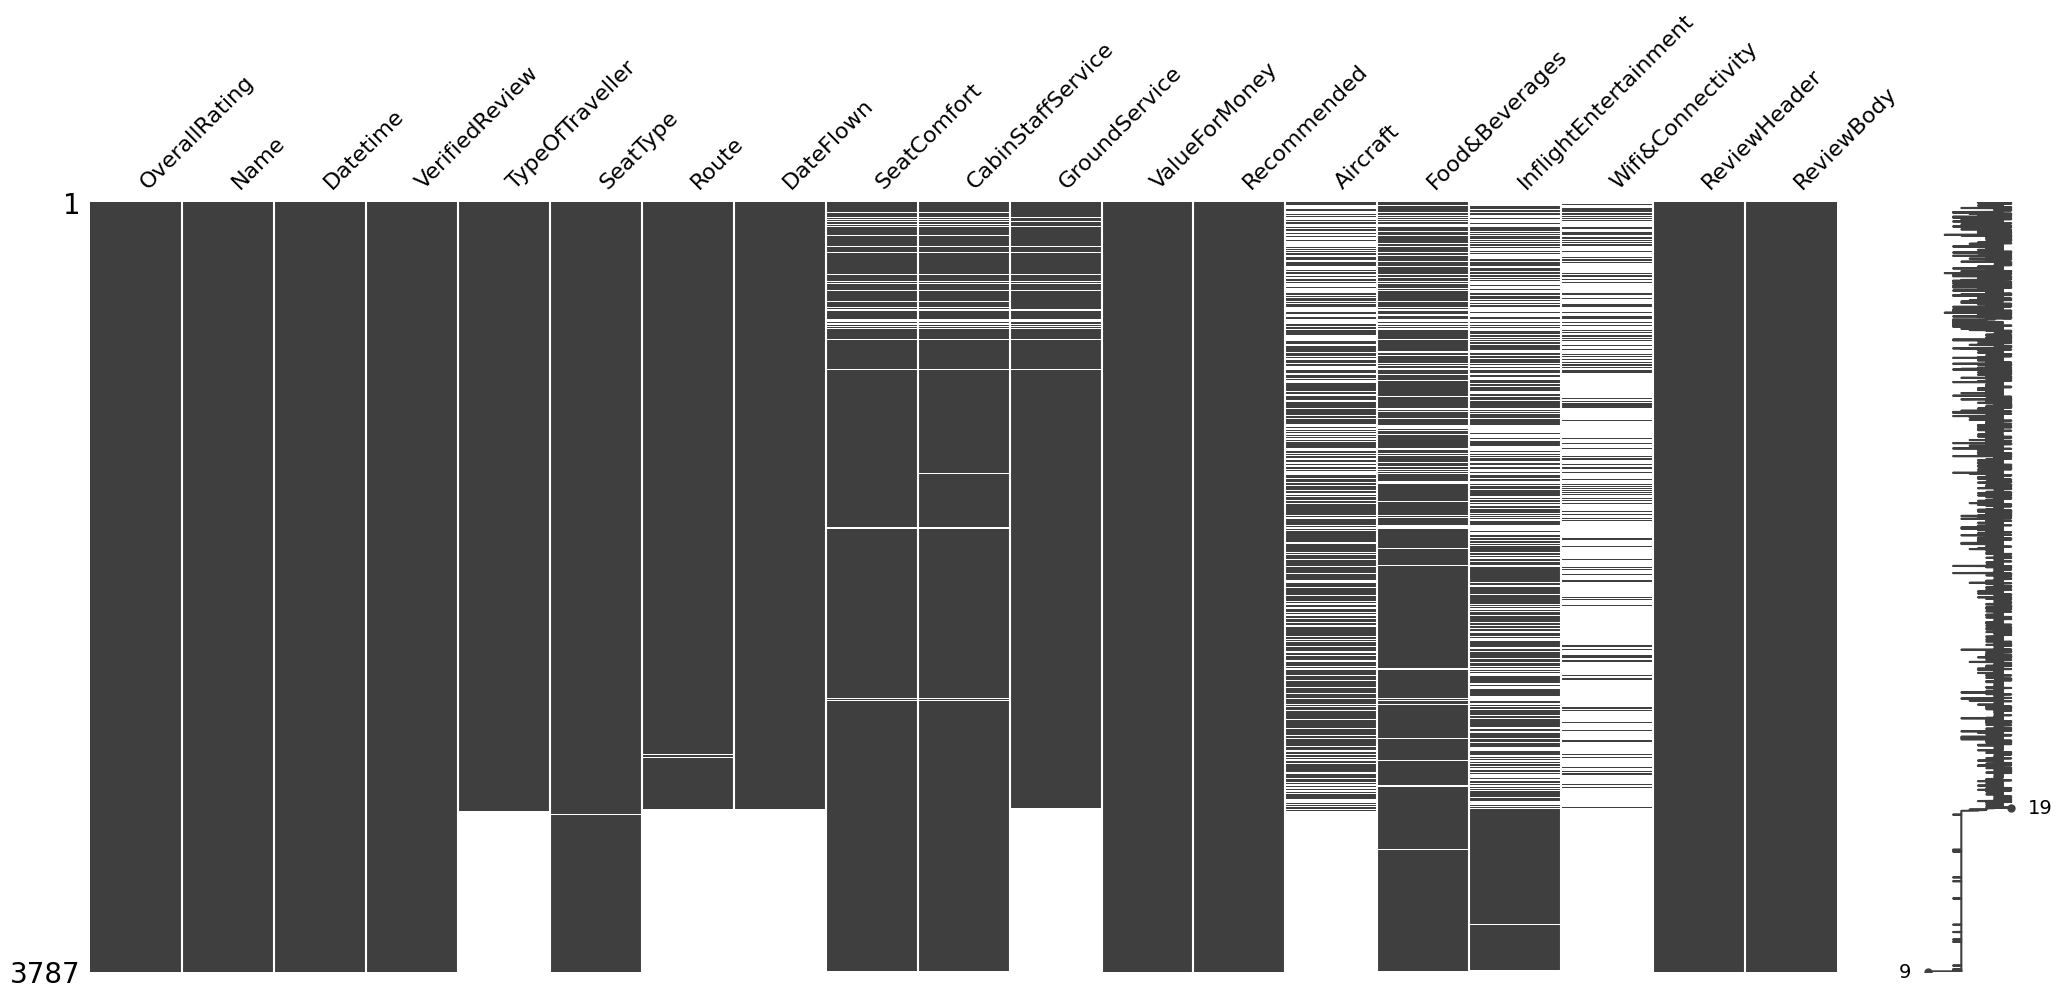

In [12]:
msno.matrix(df)
plt.show()

In [13]:
# Decided to drop 'InflightEntertainment', 'Aircraft' and 'Wifi*Connectivity' columns as it has more that 30% data missing

In [14]:
columns_to_drop = ['InflightEntertainment', 'Aircraft', 'Wifi&Connectivity']
clean_df = df.drop(columns=columns_to_drop)

In [15]:
clean_df.head()

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Food&Beverages,ReviewHeader,ReviewBody
0,1.0,L Keele,19th November 2023,True,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,"""Service level far worse then Ryanair""",4 Hours before takeoff we received a Mail stat...
1,3.0,Austin Jones,19th November 2023,True,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,1.0,"""do not upgrade members based on status""",I recently had a delay on British Airways from...
2,8.0,M A Collie,16th November 2023,False,Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,4.0,"""Flight was smooth and quick""","Boarded on time, but it took ages to get to th..."
3,1.0,Nigel Dean,16th November 2023,True,Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,"""Absolutely hopeless airline""","5 days before the flight, we were advised by B..."
4,1.0,Gaylynne Simpson,14th November 2023,False,Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,1.0,"""Customer Service is non existent""","We traveled to Lisbon for our dream vacation, ..."


In [16]:
clean_df.shape

(3787, 16)

### Convert to datetime

In [17]:
clean_df['Datetime']

0       19th November 2023
1       19th November 2023
2       16th November 2023
3       16th November 2023
4       14th November 2023
               ...        
3782      29th August 2012
3783      28th August 2012
3784     12th October 2011
3785     11th October 2011
3786      9th October 2011
Name: Datetime, Length: 3787, dtype: object

In [18]:
clean_df['Datetime'] = pd.to_datetime(clean_df['Datetime'])
clean_df['DateFlown'] = pd.to_datetime(clean_df['DateFlown'])

In [19]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3786
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OverallRating      3782 non-null   float64       
 1   Name               3787 non-null   object        
 2   Datetime           3787 non-null   datetime64[ns]
 3   VerifiedReview     3787 non-null   bool          
 4   TypeOfTraveller    2990 non-null   object        
 5   SeatType           3785 non-null   object        
 6   Route              2986 non-null   object        
 7   DateFlown          2983 non-null   datetime64[ns]
 8   SeatComfort        3671 non-null   float64       
 9   CabinStaffService  3660 non-null   float64       
 10  GroundService      2913 non-null   float64       
 11  ValueForMoney      3786 non-null   float64       
 12  Recommended        3787 non-null   object        
 13  Food&Beverages     3398 non-null   float64       
 14  ReviewHe

## Check brief statistical summary

In [20]:
clean_df.describe()

,OverallRating,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Food&Beverages
count,3782.000000,3671.000000,3660.000000,2913.000000,3786.000000,3398.000000
mean,4.769434,2.884500,3.267213,2.788534,2.701532,2.721601
std,3.188222,1.365498,1.490304,1.458649,1.477683,1.439654
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
50%,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,8.000000,4.000000,5.000000,4.000000,4.000000,4.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000


### Distribution of Overall Rating

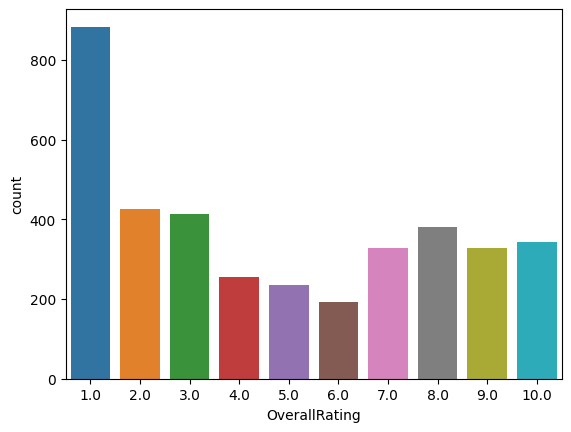

In [21]:
sns.countplot(clean_df.OverallRating);

In [22]:
counts = clean_df.OverallRating.value_counts()
counts

1.0     883
2.0     426
3.0     412
8.0     380
10.0    344
9.0     328
7.0     327
4.0     256
5.0     234
6.0     192
Name: OverallRating, dtype: int64

<BarContainer object of 10 artists>

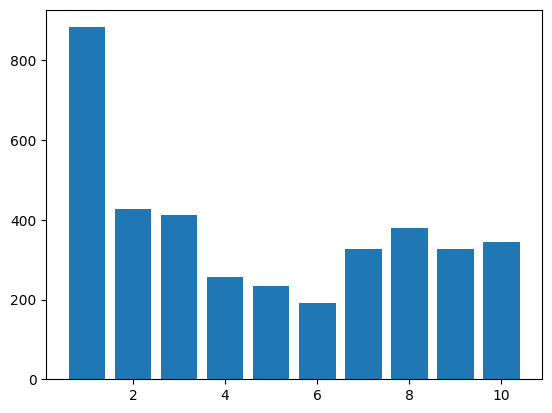

In [23]:
plt.bar(counts.index, counts.values)

### Average rating for each category

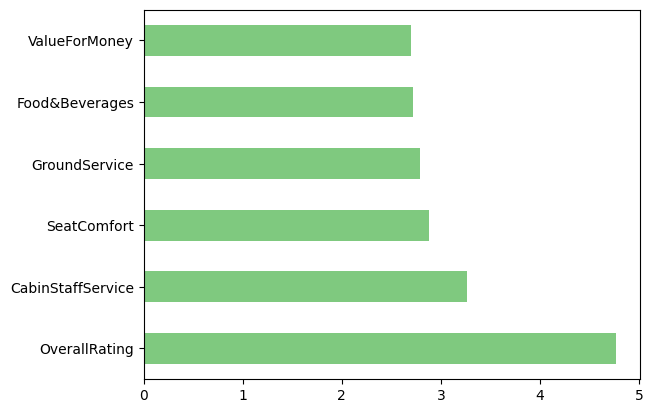

In [24]:
clean_df.select_dtypes(include='float64').describe().iloc[1].sort_values(ascending=False).plot(kind='barh', cmap=cm.Accent, edgecolor='None');

<AxesSubplot:>

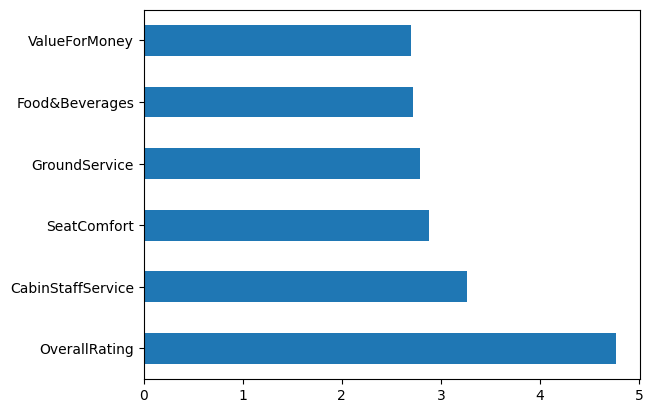

In [25]:
clean_df.describe().iloc[1].sort_values(ascending=False).plot(kind='barh')

### Visual Correlation

In [26]:
clean_df.corr()

,OverallRating,VerifiedReview,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Food&Beverages
OverallRating,1.000000,-0.105386,0.743898,0.724361,0.732719,0.875486,0.763645
VerifiedReview,-0.105386,1.000000,-0.065140,-0.051469,-0.050192,-0.103257,-0.020737
SeatComfort,0.743898,-0.065140,1.000000,0.593228,0.544076,0.703788,0.621875
CabinStaffService,0.724361,-0.051469,0.593228,1.000000,0.527409,0.658363,0.706878
GroundService,0.732719,-0.050192,0.544076,0.527409,1.000000,0.676865,0.517157
ValueForMoney,0.875486,-0.103257,0.703788,0.658363,0.676865,1.000000,0.714885
Food&Beverages,0.763645,-0.020737,0.621875,0.706878,0.517157,0.714885,1.000000


<AxesSubplot:>

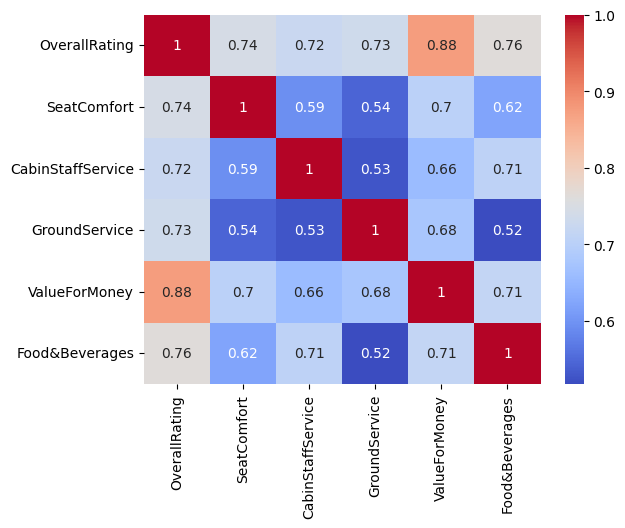

In [27]:
sns.heatmap(clean_df.select_dtypes(include='number').corr(), cmap='coolwarm', annot = True)

As expected all ratings are highly correlated with Overall Rating, Value for money bein the most related metric.

### yearly plot

<AxesSubplot:xlabel='Datetime'>

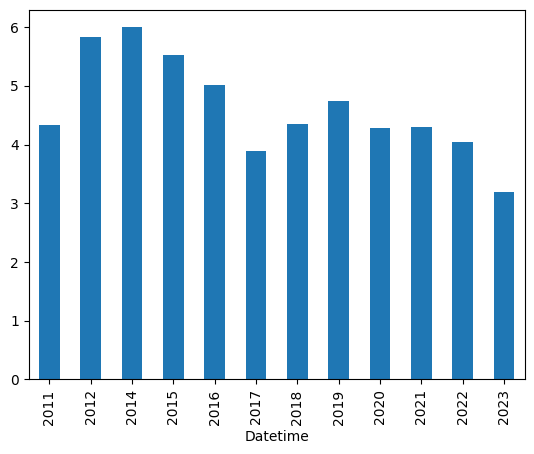

In [28]:
clean_df.groupby(clean_df.Datetime.dt.year)['OverallRating'].mean().plot(kind='bar')

## Type Of Travellers & Seat Types

In [29]:
clean_df.head()

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Food&Beverages,ReviewHeader,ReviewBody
0,1.0,L Keele,2023-11-19,True,Couple Leisure,Economy Class,London to Stuttgart,2023-11-01,1.0,1.0,1.0,1.0,no,NaN,"""Service level far worse then Ryanair""",4 Hours before takeoff we received a Mail stat...
1,3.0,Austin Jones,2023-11-19,True,Business,Economy Class,Brussels to London,2023-11-01,2.0,3.0,1.0,2.0,no,1.0,"""do not upgrade members based on status""",I recently had a delay on British Airways from...
2,8.0,M A Collie,2023-11-16,False,Couple Leisure,Business Class,London Heathrow to Dublin,2023-11-01,3.0,3.0,4.0,3.0,yes,4.0,"""Flight was smooth and quick""","Boarded on time, but it took ages to get to th..."
3,1.0,Nigel Dean,2023-11-16,True,Couple Leisure,Economy Class,London to Dublin,2022-12-01,3.0,3.0,1.0,1.0,no,NaN,"""Absolutely hopeless airline""","5 days before the flight, we were advised by B..."
4,1.0,Gaylynne Simpson,2023-11-14,False,Couple Leisure,Economy Class,London to Lisbon,2023-11-01,1.0,1.0,1.0,1.0,no,1.0,"""Customer Service is non existent""","We traveled to Lisbon for our dream vacation, ..."


In [30]:
clean_df.TypeOfTraveller.value_counts(normalize=True)

Couple Leisure    0.339799
Solo Leisure      0.307692
Business          0.217391
Family Leisure    0.135117
Name: TypeOfTraveller, dtype: float64

In [31]:
clean_df.SeatType.value_counts(normalize=True)

Economy Class      0.516513
Business Class     0.327873
Premium Economy    0.097226
First Class        0.058388
Name: SeatType, dtype: float64

### Average rating for each categories

In [32]:
clean_df.groupby(by='TypeOfTraveller')[['OverallRating']].mean().sort_values(by='OverallRating', ascending=False)

,OverallRating
TypeOfTraveller,
Solo Leisure,5.063043
Couple Leisure,4.537402
Family Leisure,4.321782
Business,3.486154


In [33]:
clean_df.groupby('SeatType')[['OverallRating']].mean().sort_values(by='OverallRating', ascending=False)

,OverallRating
SeatType,
First Class,6.081818
Business Class,5.166129
Premium Economy,4.934783
Economy Class,4.340676


<AxesSubplot:ylabel='TypeOfTraveller,SeatType'>

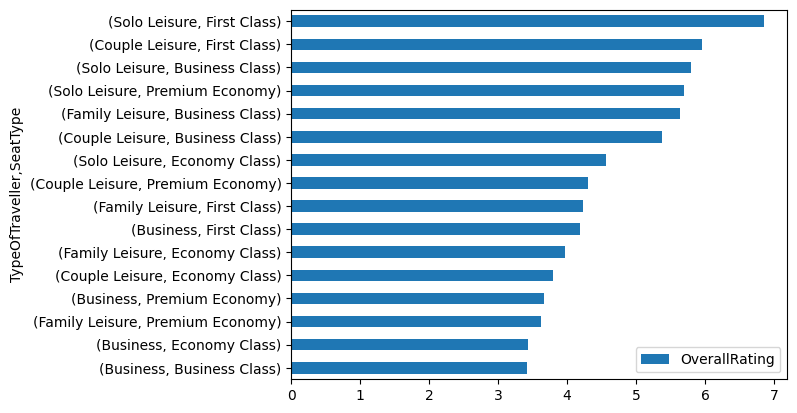

In [34]:
clean_df.groupby(['TypeOfTraveller', 'SeatType'])[['OverallRating']].mean().sort_values(by='OverallRating', ascending=True).plot(kind='barh')

Most Satisfied: 
`Solo Lesuire` & `First Class`

Least Satisfied:
`Business` & `Economy Class`

# Simple regression model for recommendation prediction

Simple Decision Tree Regression model, focusing on Type Of Traveller and Seat Type

In [35]:
cat_df = clean_df[['TypeOfTraveller', 'SeatType', 'Recommended']].dropna()
cat_df.isnull().sum()

TypeOfTraveller    0
SeatType           0
Recommended        0
dtype: int64

In [36]:
ohe = OneHotEncoder(sparse_output=False, drop='if_binary')
cat_ohe = ohe.fit_transform(cat_df)
cat_features = pd.DataFrame(cat_ohe, columns=ohe.get_feature_names_out())
cat_features.head()

,TypeOfTraveller_Business,TypeOfTraveller_Couple Leisure,TypeOfTraveller_Family Leisure,TypeOfTraveller_Solo Leisure,SeatType_Business Class,SeatType_Economy Class,SeatType_First Class,SeatType_Premium Economy,Recommended_yes
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
model = LogisticRegression()

In [38]:
params = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [39]:
clf = GridSearchCV(model,                    # model
                   param_grid = params,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [40]:
X = cat_features.drop(columns = 'Recommended_yes')
y = cat_features['Recommended_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [41]:
clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [42]:
clf.best_estimator_.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [43]:
clf.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [44]:
clf.best_score_

0.6507810320781032

In [45]:
y_pred = clf.predict(X_test)

In [46]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6438127090301003


# NLP

In [47]:
clean_df.head()

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Food&Beverages,ReviewHeader,ReviewBody
0,1.0,L Keele,2023-11-19,True,Couple Leisure,Economy Class,London to Stuttgart,2023-11-01,1.0,1.0,1.0,1.0,no,NaN,"""Service level far worse then Ryanair""",4 Hours before takeoff we received a Mail stat...
1,3.0,Austin Jones,2023-11-19,True,Business,Economy Class,Brussels to London,2023-11-01,2.0,3.0,1.0,2.0,no,1.0,"""do not upgrade members based on status""",I recently had a delay on British Airways from...
2,8.0,M A Collie,2023-11-16,False,Couple Leisure,Business Class,London Heathrow to Dublin,2023-11-01,3.0,3.0,4.0,3.0,yes,4.0,"""Flight was smooth and quick""","Boarded on time, but it took ages to get to th..."
3,1.0,Nigel Dean,2023-11-16,True,Couple Leisure,Economy Class,London to Dublin,2022-12-01,3.0,3.0,1.0,1.0,no,NaN,"""Absolutely hopeless airline""","5 days before the flight, we were advised by B..."
4,1.0,Gaylynne Simpson,2023-11-14,False,Couple Leisure,Economy Class,London to Lisbon,2023-11-01,1.0,1.0,1.0,1.0,no,1.0,"""Customer Service is non existent""","We traveled to Lisbon for our dream vacation, ..."


In [48]:
clean_df['ReviewHeader'] = clean_df.ReviewHeader.str.replace('"', '')

In [49]:
clean_df['FullReview'] = clean_df['ReviewHeader'] + str(' ') + clean_df['ReviewBody']

In [50]:
clean_df['FullReview']

0       Service level far worse then Ryanair 4 Hours b...
1       do not upgrade members based on status I recen...
2       Flight was smooth and quick Boarded on time, b...
3       Absolutely hopeless airline 5 days before the ...
4       Customer Service is non existent We traveled t...
                              ...                        
3782    British Airways customer review This was a bmi...
3783    British Airways customer review LHR to HAM. Pu...
3784    British Airways customer review My son who had...
3785    British Airways customer review London City-Ne...
3786    British Airways customer review SIN-LHR BA12 B...
Name: FullReview, Length: 3787, dtype: object

In [51]:
def clean(text):
    for puncuation in string.punctuation:
        text = text.replace(puncuation, ' ')
    
    lowercase = text.lower()
    tokenised = word_tokenize(lowercase)
    word_only = [word for word in tokenised if word.isalpha()]
    
    # Removing words appeared too frequently - which isn't necessary for analysis
    manual_sw = ['ba', 'flight', 'british', 'airways', 'seat', 'class', 'business', 'first'
                'economy', 'premium', 'plane', 'airline', 'london', 'fly']
    
    stop_words = list(stopwords.words('english'))
    stop_words.extend(manual_sw)
    
    without_stopword = [word for word in word_only if word not in stop_words]
    
    verb_lemmatized = [ WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in without_stopword ]
    
    noun_lemmatised = [ WordNetLemmatizer().lemmatize(word, pos='n')
                      for word in verb_lemmatized ]
    
    return " ".join(noun_lemmatised)
        
    

In [52]:
clean_df['clean_review'] = clean_df['FullReview'].apply(clean)
clean_df['clean_review']

0       service level far worse ryanair hour takeoff r...
1       upgrade member base status recently delay bru ...
2       smooth quick board time take age get runway du...
3       absolutely hopeless day advise cancel ask u re...
4       customer service non existent travel lisbon dr...
                              ...                        
3782    customer review bmi regional operate mancheste...
3783    customer review lhr ham purser address club pa...
3784    customer review son work urge kansa city recom...
3785    customer review city new york jfk via shannon ...
3786    customer review sin lhr first old aircraft sea...
Name: clean_review, Length: 3787, dtype: object

In [53]:
small_df = clean_df[['OverallRating', 'Datetime', 'TypeOfTraveller', 'SeatType', 'clean_review']]
small_df.head()

,OverallRating,Datetime,TypeOfTraveller,SeatType,clean_review
0,1.0,2023-11-19,Couple Leisure,Economy Class,service level far worse ryanair hour takeoff r...
1,3.0,2023-11-19,Business,Economy Class,upgrade member base status recently delay bru ...
2,8.0,2023-11-16,Couple Leisure,Business Class,smooth quick board time take age get runway du...
3,1.0,2023-11-16,Couple Leisure,Economy Class,absolutely hopeless day advise cancel ask u re...
4,1.0,2023-11-14,Couple Leisure,Economy Class,customer service non existent travel lisbon dr...


In [54]:
len(small_df.clean_review[0])

429

In [55]:
small_df.groupby(['TypeOfTraveller', 'SeatType'])\
[['OverallRating', 'clean_review']]\
.agg({'OverallRating': 'mean', 'clean_review': 'sum'})

OverallRating  \
TypeOfTraveller SeatType                         
Business        Business Class        3.412969   
                Economy Class         3.430189   
                First Class           4.184211   
                Premium Economy       3.666667   
Couple Leisure  Business Class        5.373596   
                Economy Class         3.799595   
                First Class           5.953125   
                Premium Economy       4.303922   
Family Leisure  Business Class        5.636364   
                Economy Class         3.974729   
                First Class           4.230769   
                Premium Economy       3.615385   
Solo Leisure    Business Class        5.803109   
                Economy Class         4.569948   
                First Class           6.851064   
                Premium Economy       5.690000   

                                                                      clean_review  
TypeOfTraveller SeatType                                                            
Business        Business Class   club europe simply joke frequent flyer last ye...  
                Economy Class    upgrade member base status recently delay bru ...  
                First Class      expect product travel back mexico city trip fu...  
                Premium Economy  single feedback initial cancel hour prior auto...  
Couple Leisure  Business Class   smooth quick board time take age get runway du...  
                Economy Class    service level far worse ryanair hour takeoff r...  
                First Class      disappoint airplane lounge wear old break dall...  
                Premium Economy  sufficient leg arm room book online month ago ...  
Family Leisure  Business Class   cabin crew fantastic easy check gallery south ...  
                Economy Class    angry disappoint unsatisfied angry disappoint ...  
                First Class      overall journey great shanghai concorde room h...  
                Premium Economy  short change passenger treat economy passenger...  
Solo Leisure    Business Class   customer service disgrace fly istanbul half ch...  
                Economy Class    imagine worst book bucharest manchester layove...  
                First Class      excellent service level excellent service leve...  
                Premium Economy  pleasant experience second time economy newer ...

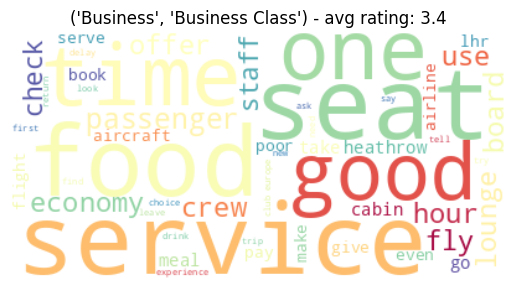

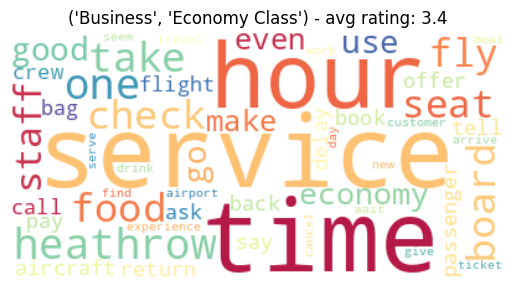

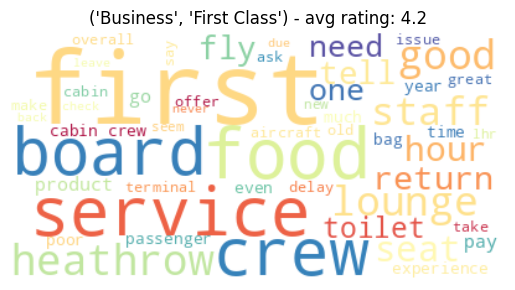

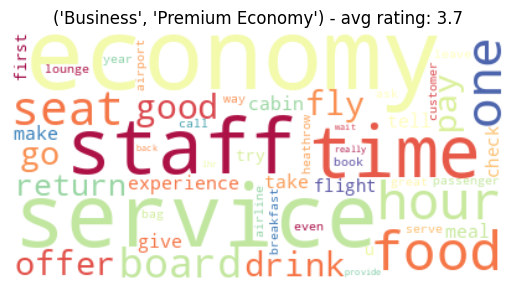

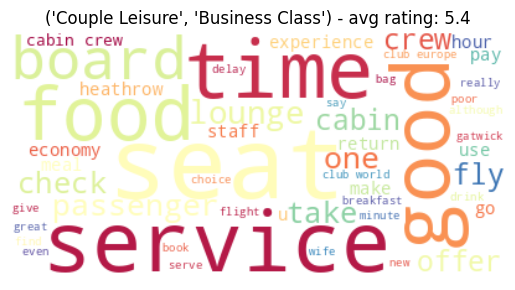

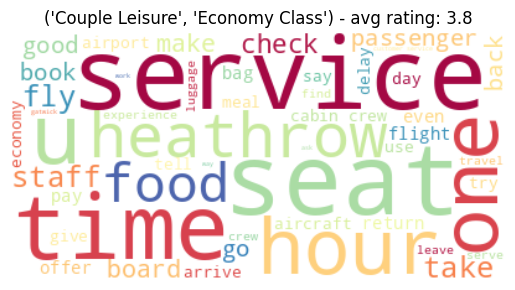

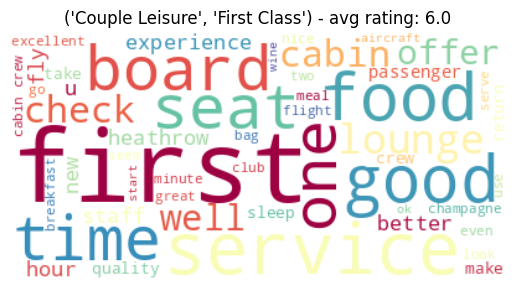

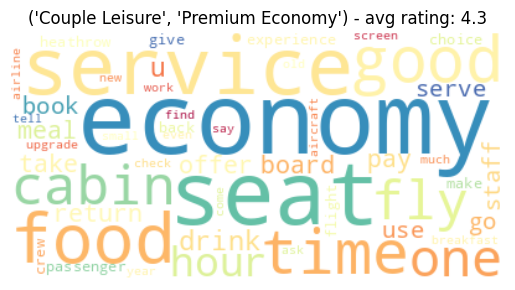

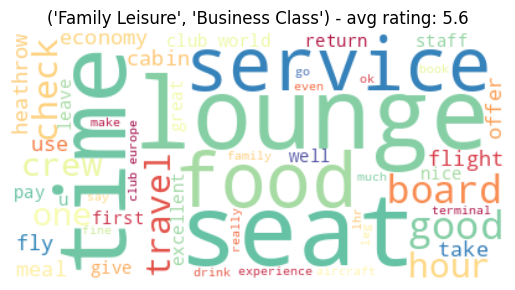

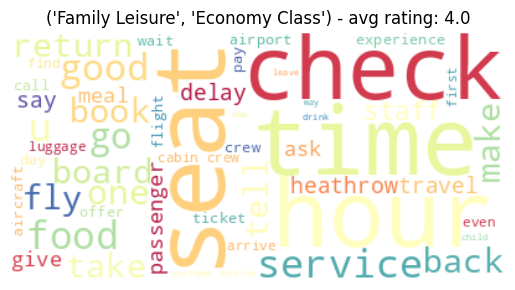

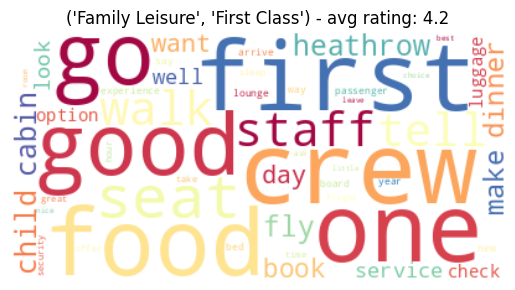

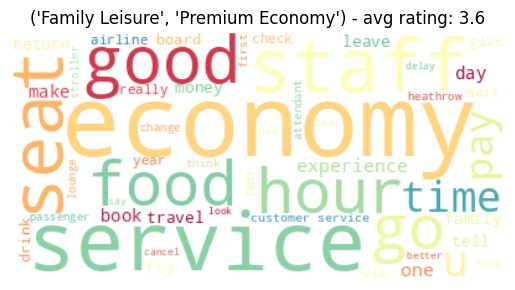

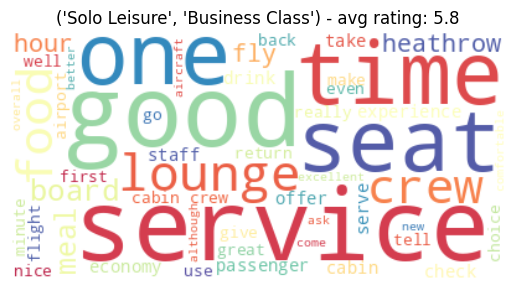

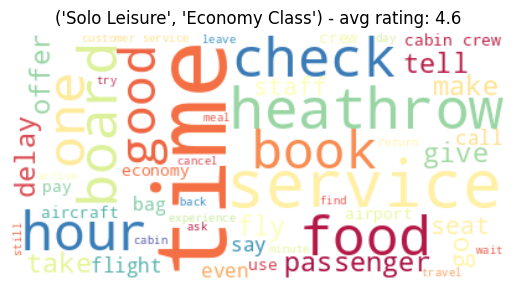

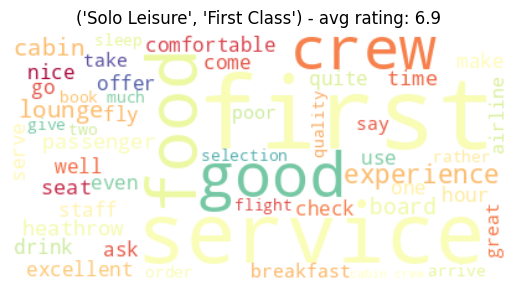

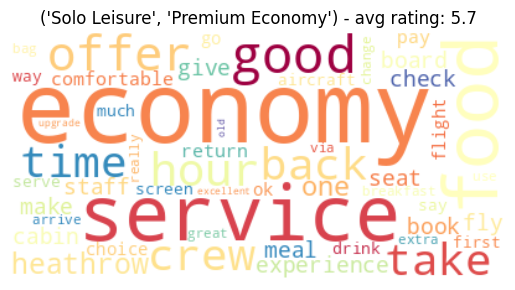

In [66]:
for cat, text in small_df.groupby(['TypeOfTraveller', 'SeatType'])[['clean_review', 'OverallRating']].agg({'OverallRating': 'mean', 'clean_review':'sum'}).iterrows():
    avg_rating = round(text['OverallRating'], 1)
    wordcloud = WordCloud(colormap=cm.Spectral_r, max_font_size=80, max_words=50, background_color="white").generate(text['clean_review'])
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'{cat} - avg rating: {avg_rating}')
    plt.axis("off")
    plt.show()